In [1]:
!pip install amazon-textract-textractor[pdfium]==1.8.2 --quiet

In [6]:
!pip install sagemaker --quiet
import os
#os.environ["AWS_PROFILE"] = "almorano"
os.environ["AWS_DEFAULT_REGION"] = "us-east-1"


In [8]:
del os.environ["AWS_PROFILE"]

In [9]:
import sagemaker

# Get the SageMaker session and default bucket
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
print(f"Default sagemaker bucket: {default_bucket}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Default sagemaker bucket: sagemaker-us-east-1-157011355455


In [10]:
#download a pdf if required
sample_paper_url = "https://arxiv.org/pdf/1706.03762"
!wget -O ./data/my_document.pdf {sample_paper_url} --no-check-certificate

--2024-08-26 08:20:17--  https://arxiv.org/pdf/1706.03762
Resolving arxiv.org (arxiv.org)... 151.101.3.42, 151.101.131.42, 151.101.67.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.3.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2215244 (2.1M) [application/pdf]
Saving to: ‘./data/my_document.pdf’

100%[======================================>] 2,215,244   --.-K/s   in 0.01s   

2024-08-26 08:20:17 (155 MB/s) - ‘./data/my_document.pdf’ saved [2215244/2215244]



In [11]:
#copy data folder with sample pdf files to S3"
!aws s3 sync ./data s3://{default_bucket}/data

upload: data/attention_is_all_you_need-10-pages.pdf to s3://sagemaker-us-east-1-157011355455/data/attention_is_all_you_need-10-pages.pdf
upload: data/attention_is_all_you_need.pdf to s3://sagemaker-us-east-1-157011355455/data/attention_is_all_you_need.pdf
upload: data/.ipynb_checkpoints/attention_is_all_you_need-checkpoint.pdf to s3://sagemaker-us-east-1-157011355455/data/.ipynb_checkpoints/attention_is_all_you_need-checkpoint.pdf
upload: data/paper-sample-10-pages.pdf to s3://sagemaker-us-east-1-157011355455/data/paper-sample-10-pages.pdf
upload: data/2023.01.11.523679v1.full.pdf to s3://sagemaker-us-east-1-157011355455/data/2023.01.11.523679v1.full.pdf
upload: data/my_document.pdf to s3://sagemaker-us-east-1-157011355455/data/my_document.pdf


In [12]:
document = "data/paper-sample-10-pages.pdf"
document = "data/my_document.pdf"
document_s3_url = f"s3://{default_bucket}/{document}"

In [13]:
import os
from textractor import Textractor
from textractor.data.constants import TextractFeatures

In [14]:
from textractor import Textractor
from textractor.data.constants import TextractFeatures
from textractor.data.text_linearization_config import TextLinearizationConfig

extractor = Textractor()
document = extractor.start_document_analysis(
    document_s3_url,    
    features=[TextractFeatures.LAYOUT, TextractFeatures.FORMS, TextractFeatures.TABLES],
    save_image=True,
)

In [15]:
document

## Using Layout Analysis

Try the [interactive Textract Demo for layout analysis](https://us-east-1.console.aws.amazon.com/textract/home?region=us-east-1#/demo) in the AWS Console.
![alt text](images/layout_analysis_attention_page_0.png "Layout analysis of first page")


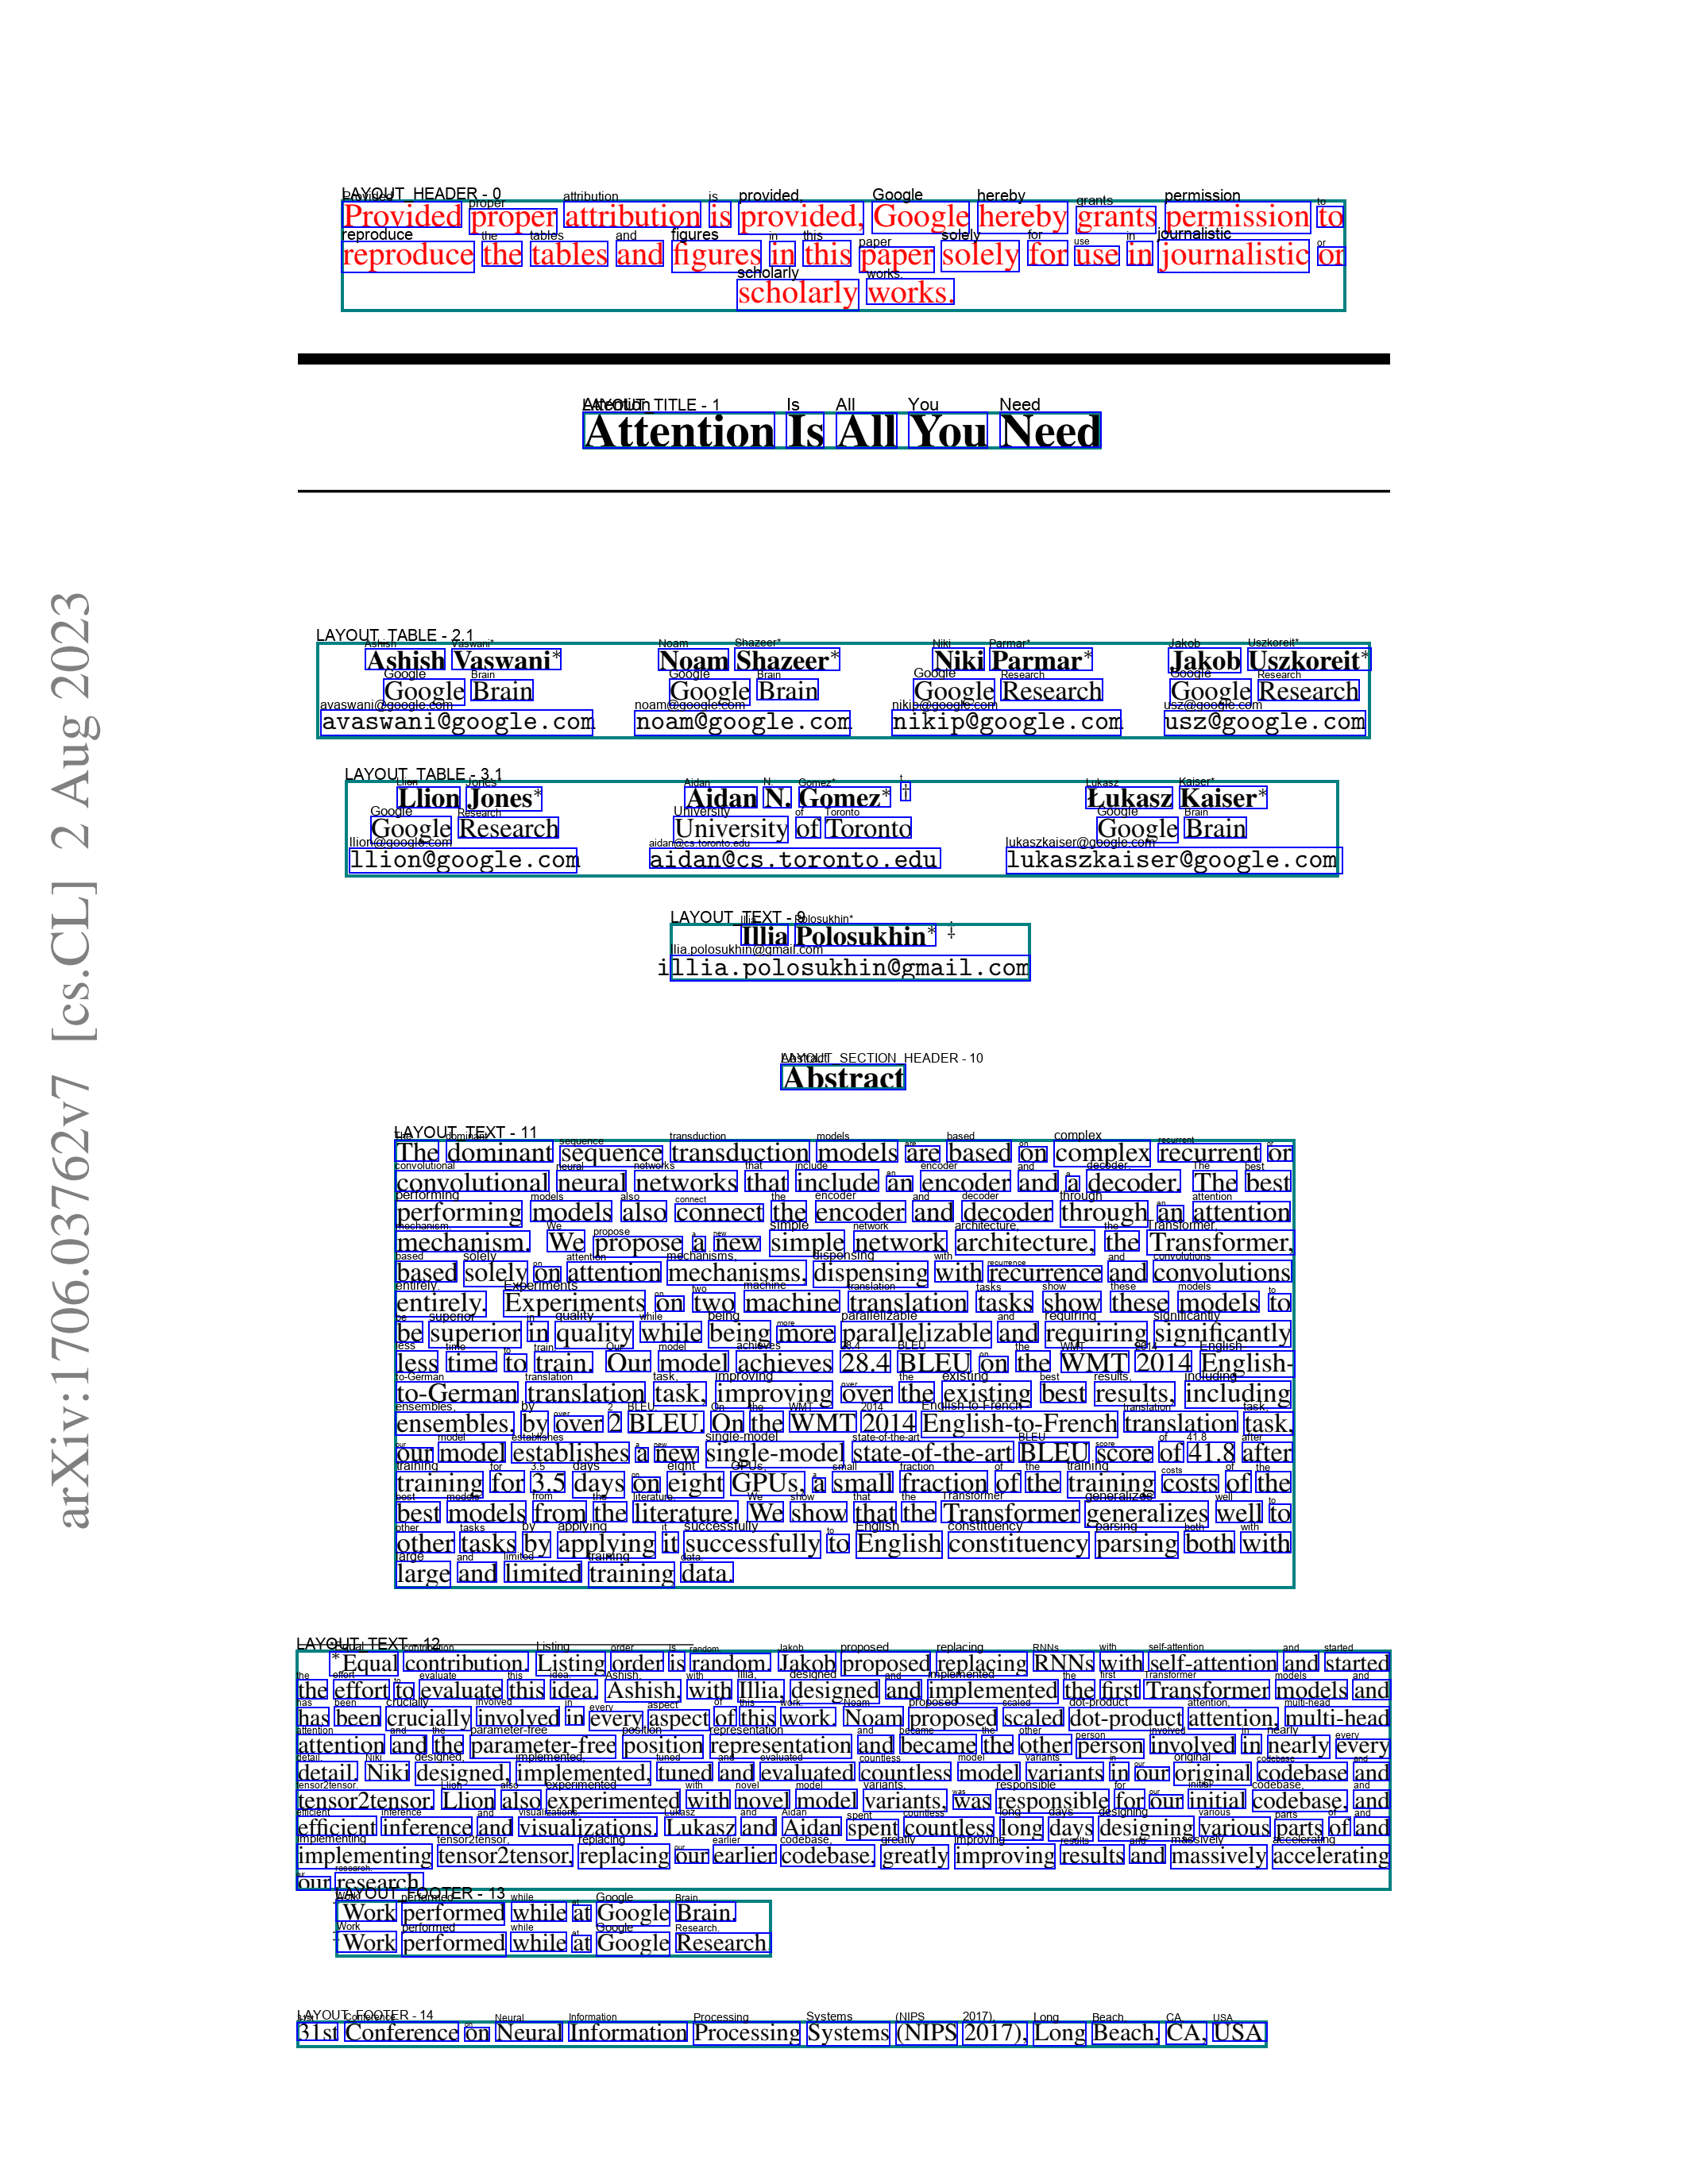

In [16]:
#document.pages[0].page_layout.titles[0].visualize().convert("RGB")
document.pages[0].layouts.visualize().convert("RGB")

In [18]:
document.tables[3]


Table
Rows - 12
Columns - 5
Cells - 60
Merged Cells - 6

In [19]:
table_aware_text = document.tables[3].get_text(TextLinearizationConfig(table_linearization_format='markdown'))
print(table_aware_text)

| Model                           | BLEU    |       | Training Cost (FLOPs)    |          |
|---------------------------------|---------|-------|--------------------------|----------|
|                                 | EN-DE   | EN-FR | EN-DE                    | EN-FR    |
| ByteNet [18]                    | 23.75   |       |                          |          |
| Deep-Att + PosUnk [39]          |         | 39.2  |                          | 1.0.1020 |
| GNMT + RL [38]                  | 24.6    | 39.92 | 2.3 1019                 | 1.4.1020 |
| ConvS2S [9]                     | 25.16   | 40.46 | 9.6.1018                 | 1.5.1020 |
| MoE [32]                        | 26.03   | 40.56 | 2.0.1019                 | 1.2.1020 |
| Deep-Att + PosUnk Ensemble [39] |         | 40.4  |                          | 8.0.1020 |
| GNMT + RL Ensemble [38]         | 26.30   | 41.16 | 1.8.1020                 | 1.1.1021 |
| ConvS2S Ensemble [9]            | 26.36   | 41.29 | 7.7.1019                 |

Iterate over all semantic units
* linearize each unit e.g. as markdow, + each single meta information, section, headers, subsection, location, etc.
* Describe figures, images, diagrams using e.g. Claude 3 vision
* Embed figures, images, diagrams directly using [Titan Image Embeddings](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-multiemb-models.html)

Dataframe with semantic chunking

# Converting to HTML


In [22]:
# helper to limit the height in our view
def wrapped_html(html):
    full_html = f"""
    <div style="max-height: 500px; overflow-y: auto;">
        {html}
    </div>
    """
    return full_html

In [23]:
from IPython.display import display, HTML

html= document.to_html()
display(HTML(wrapped_html(html)))

# Converting to Markdown

In [24]:
from IPython.display import display, Markdown
from ipywidgets import widgets, Layout

def display_markdown_with_max_height(markdown_text, max_height='300px'):
    html_content = f"""
    <div style="max-height: {max_height}; overflow-y: auto;">    
    <pre style="margin: 0;">{Markdown(markdown_text).data}</pre>    
    </div>
    """
    display(HTML(html_content))

long_markdown = document.to_markdown()
display_markdown_with_max_height(long_markdown, max_height='300px')

# Layout-aware Chunking
 
We consider the text blocks, which are similar to paragraphs as initial chunking units. Each text block is combined with its previous title and section header.
* get each chunk (paragraph), and add the metadata (page_number, bounding_box, hierarchy list)
 sample: hierarchy list: [(header, text),(section, text), (subsection, text)]
* For each figure add a placeholder to call vision llm to get the description

In [25]:
import pandas as pd

rows = []
for layout in document.layouts:        
    row = {}    
    row["layout_type"] = layout.layout_type
    row["page"] = layout.page
    row["confidence"] = layout.confidence
    row["reading_order"] = layout.reading_order
    row["text"] = layout.get_text()
    row["words"] = layout.words
    # row["bbox"] = layout.bbox
    row["id"] = layout.id
    row.update(layout.bbox.__dict__)
    row["layout"] = layout
    row["raw_object"] = layout.raw_object
        
    del row["spatial_object"]    
    rows.append(row)    

df = pd.DataFrame(rows)

df

,layout_type,page,confidence,reading_order,text,words,id,width,height,x,y,layout,raw_object
0,LAYOUT_HEADER,1,0.573730,0.0,"Provided proper attribution is provided, Googl...","[Provided, proper, attribution, is, provided,,...",7d1db9ba-96fc-418e-bddd-70457cf5e561,0.595470,0.051000,0.202151,0.091612,<textractor.entities.layout.Layout object at 0...,"{'BlockType': 'LAYOUT_HEADER', 'Confidence': 5..."
1,LAYOUT_TITLE,1,0.718750,1.0,Attention Is All You Need,"[Attention, Is, All, You, Need]",64c26092-b75d-457c-a027-d89adfe46a43,0.307317,0.017116,0.344987,0.188435,<textractor.entities.layout.Layout object at 0...,"{'BlockType': 'LAYOUT_TITLE', 'Confidence': 71..."
2,LAYOUT_TABLE,1,0.000000,2.1,\n\nAshish Vaswani*\tNoam Shazeer*\tNiki Parma...,"[Ashish, Vaswani*, Noam, Shazeer*, Niki, Parma...",e671b939-f256-4474-bbf0-88c9690727a6,0.624299,0.044657,0.187496,0.293845,<textractor.entities.layout.Layout object at 0...,None
3,LAYOUT_TABLE,1,0.000000,3.1,\n\nLlion Jones* Google Research llion@google....,"[Llion, Jones*, Google, Research, llion@google...",58a775a9-c57c-4613-aa02-b24e7f554111,0.588784,0.044130,0.204308,0.357417,<textractor.entities.layout.Layout object at 0...,None
4,LAYOUT_TEXT,1,0.972168,9.0,Illia Polosukhin* llia.polosukhin@gmail.com,"[Illia, Polosukhin*, llia.polosukhin@gmail.com]",b8555d68-82c7-4f46-98e4-b972adb63da9,0.213723,0.026663,0.396961,0.422766,<textractor.entities.layout.Layout object at 0...,"{'BlockType': 'LAYOUT_TEXT', 'Confidence': 97...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,LAYOUT_TABLE,13,0.000000,1.1,\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,"[[ ], [ ]]",8fcb740b-50b4-4f91-941a-100633e9cef0,0.644876,0.269442,0.179979,0.116386,<textractor.entities.layout.Layout object at 0...,None
142,LAYOUT_TEXT,13,0.949219,2.0,3: Figure An example of the attention mechani...,"[3:, Figure, An, example, of, the, attention, ...",6d7c5e47-2c3d-4dfb-8f2e-54bcd58158c7,0.649391,0.078964,0.175532,0.380285,<textractor.entities.layout.Layout object at 0...,"{'BlockType': 'LAYOUT_TEXT', 'Confidence': 94...."
143,LAYOUT_PAGE_NUMBER,13,0.905273,3.0,13\n,[13],92823ed0-e709-4e88-ba73-d679e4c8a83c,0.014990,0.010491,0.492722,0.937326,<textractor.entities.layout.Layout object at 0...,"{'BlockType': 'LAYOUT_PAGE_NUMBER', 'Confidenc..."
144,LAYOUT_TABLE,14,0.000000,0.1,\n\n\t\t\tThe\n\t\tThe\tLaw\n\t\t\twill\n\tThe...,"[The, The, Law, will, The, Law, will, never, L...",227b39ea-e6a7-4ed8-b58b-1d1b542f1f75,0.880090,0.704096,0.076095,0.156549,<textractor.entities.layout.Layout object at 0...,None


In [26]:
df.dtypes

layout_type       object
page               int64
confidence       float64
reading_order    float64
text              object
words             object
id                object
width            float64
height           float64
x                float64
y                float64
layout            object
raw_object        object
dtype: object

In [27]:
set(df["layout_type"].values)


{'LAYOUT_FIGURE',
 'LAYOUT_FOOTER',
 'LAYOUT_HEADER',
 'LAYOUT_KEY_VALUE',
 'LAYOUT_LIST',
 'LAYOUT_PAGE_NUMBER',
 'LAYOUT_SECTION_HEADER',
 'LAYOUT_TABLE',
 'LAYOUT_TEXT',
 'LAYOUT_TITLE'}

In [28]:
# add header/section columns and rolling fill the chunks with the upper value of header/section
def forward_fill_column(df, col_name, header_value):
    # Step 1: Create a boolean mask for LAYOUT_HEADER rows
    header_mask = df[col_name] == header_value
    # Step 2: Create a new column 'header_value' initialized with NaN
    df[header_value] = pd.NA
    # Step 3: Set value for mask
    df.loc[header_mask, header_value] = df.loc[header_mask, 'text']
    # Step 4: Forward fill the header values
    df[header_value] = df[header_value].ffill()    
    # Step 5: Set 'header_value' to NaN for LAYOUT_HEADER rows
    df.loc[header_mask, header_value] = pd.NA

    return df

# df = forward_fill_column(df, "layout_type","LAYOUT_HEADER")
df = forward_fill_column(df, "layout_type","LAYOUT_TITLE")
df = forward_fill_column(df, "layout_type","LAYOUT_SECTION_HEADER")
df[["layout_type", "LAYOUT_TITLE", "LAYOUT_SECTION_HEADER", "page","text"]].head(10)

,layout_type,LAYOUT_TITLE,LAYOUT_SECTION_HEADER,page,text
0,LAYOUT_HEADER,<NA>,<NA>,1,"Provided proper attribution is provided, Googl..."
1,LAYOUT_TITLE,<NA>,<NA>,1,Attention Is All You Need
2,LAYOUT_TABLE,Attention Is All You Need,<NA>,1,\n\nAshish Vaswani*\tNoam Shazeer*\tNiki Parma...
3,LAYOUT_TABLE,Attention Is All You Need,<NA>,1,\n\nLlion Jones* Google Research llion@google....
4,LAYOUT_TEXT,Attention Is All You Need,<NA>,1,Illia Polosukhin* llia.polosukhin@gmail.com
5,LAYOUT_SECTION_HEADER,Attention Is All You Need,<NA>,1,Abstract
6,LAYOUT_TEXT,Attention Is All You Need,Abstract,1,The dominant sequence transduction models are ...
7,LAYOUT_TEXT,Attention Is All You Need,Abstract,1,*Equal contribution. Listing order is random....
8,LAYOUT_FOOTER,Attention Is All You Need,Abstract,1,Work performed while at Google Brain.\n Work p...
9,LAYOUT_FOOTER,Attention Is All You Need,Abstract,1,\n31st Conference on Neural Information Proces...


In [29]:

config = TextLinearizationConfig(table_linearization_format='markdown')
chunk_values = []
for i, row in df.iterrows():
    
    prefix = ""
    if not pd.isna(row.LAYOUT_SECTION_HEADER):
        prefix = f"# {row.LAYOUT_SECTION_HEADER}\n\n"    
    chunk_text, chunk_words = row.layout.get_text_and_words(config)
    
    if row.layout_type == "LAYOUT_FIGURE":
        # get additional description using vision llm
        print(row)
    
    chunk_text_final = prefix + chunk_text
    chunk_values.append(chunk_text_final)
    
df["chunk_text"] = chunk_values

df[["layout_type", "LAYOUT_TITLE", "LAYOUT_SECTION_HEADER", "page","chunk_text"]].head(10)

layout_type                                                  LAYOUT_FIGURE
page                                                                     3
confidence                                                        0.993164
reading_order                                                          0.0
text                     Output\n\nProbabilities\n\nSoftmax \n\nLinear ...
words                    [Output, Probabilities, Softmax, Linear, Add, ...
id                                    b4ce26a8-c084-4169-959f-e6a4a3e53ccd
width                                                             0.360765
height                                                              0.4095
x                                                                 0.319572
y                                                                 0.090622
layout                   <textractor.entities.layout.Layout object at 0...
raw_object               {'BlockType': 'LAYOUT_FIGURE', 'Confidence': 9...
LAYOUT_TITLE             

,layout_type,LAYOUT_TITLE,LAYOUT_SECTION_HEADER,page,chunk_text
0,LAYOUT_HEADER,<NA>,<NA>,1,"Provided proper attribution is provided, Googl..."
1,LAYOUT_TITLE,<NA>,<NA>,1,Attention Is All You Need
2,LAYOUT_TABLE,Attention Is All You Need,<NA>,1,\n\n| Ashish Vaswani* | Noam ...
3,LAYOUT_TABLE,Attention Is All You Need,<NA>,1,\n\n| 0 ...
4,LAYOUT_TEXT,Attention Is All You Need,<NA>,1,Illia Polosukhin* llia.polosukhin@gmail.com
5,LAYOUT_SECTION_HEADER,Attention Is All You Need,<NA>,1,Abstract
6,LAYOUT_TEXT,Attention Is All You Need,Abstract,1,# Abstract \n\nThe dominant sequence transduct...
7,LAYOUT_TEXT,Attention Is All You Need,Abstract,1,# Abstract \n\n *Equal contribution. Listing o...
8,LAYOUT_FOOTER,Attention Is All You Need,Abstract,1,# Abstract \n\nWork performed while at Google ...
9,LAYOUT_FOOTER,Attention Is All You Need,Abstract,1,# Abstract \n\n\n31st Conference on Neural Inf...


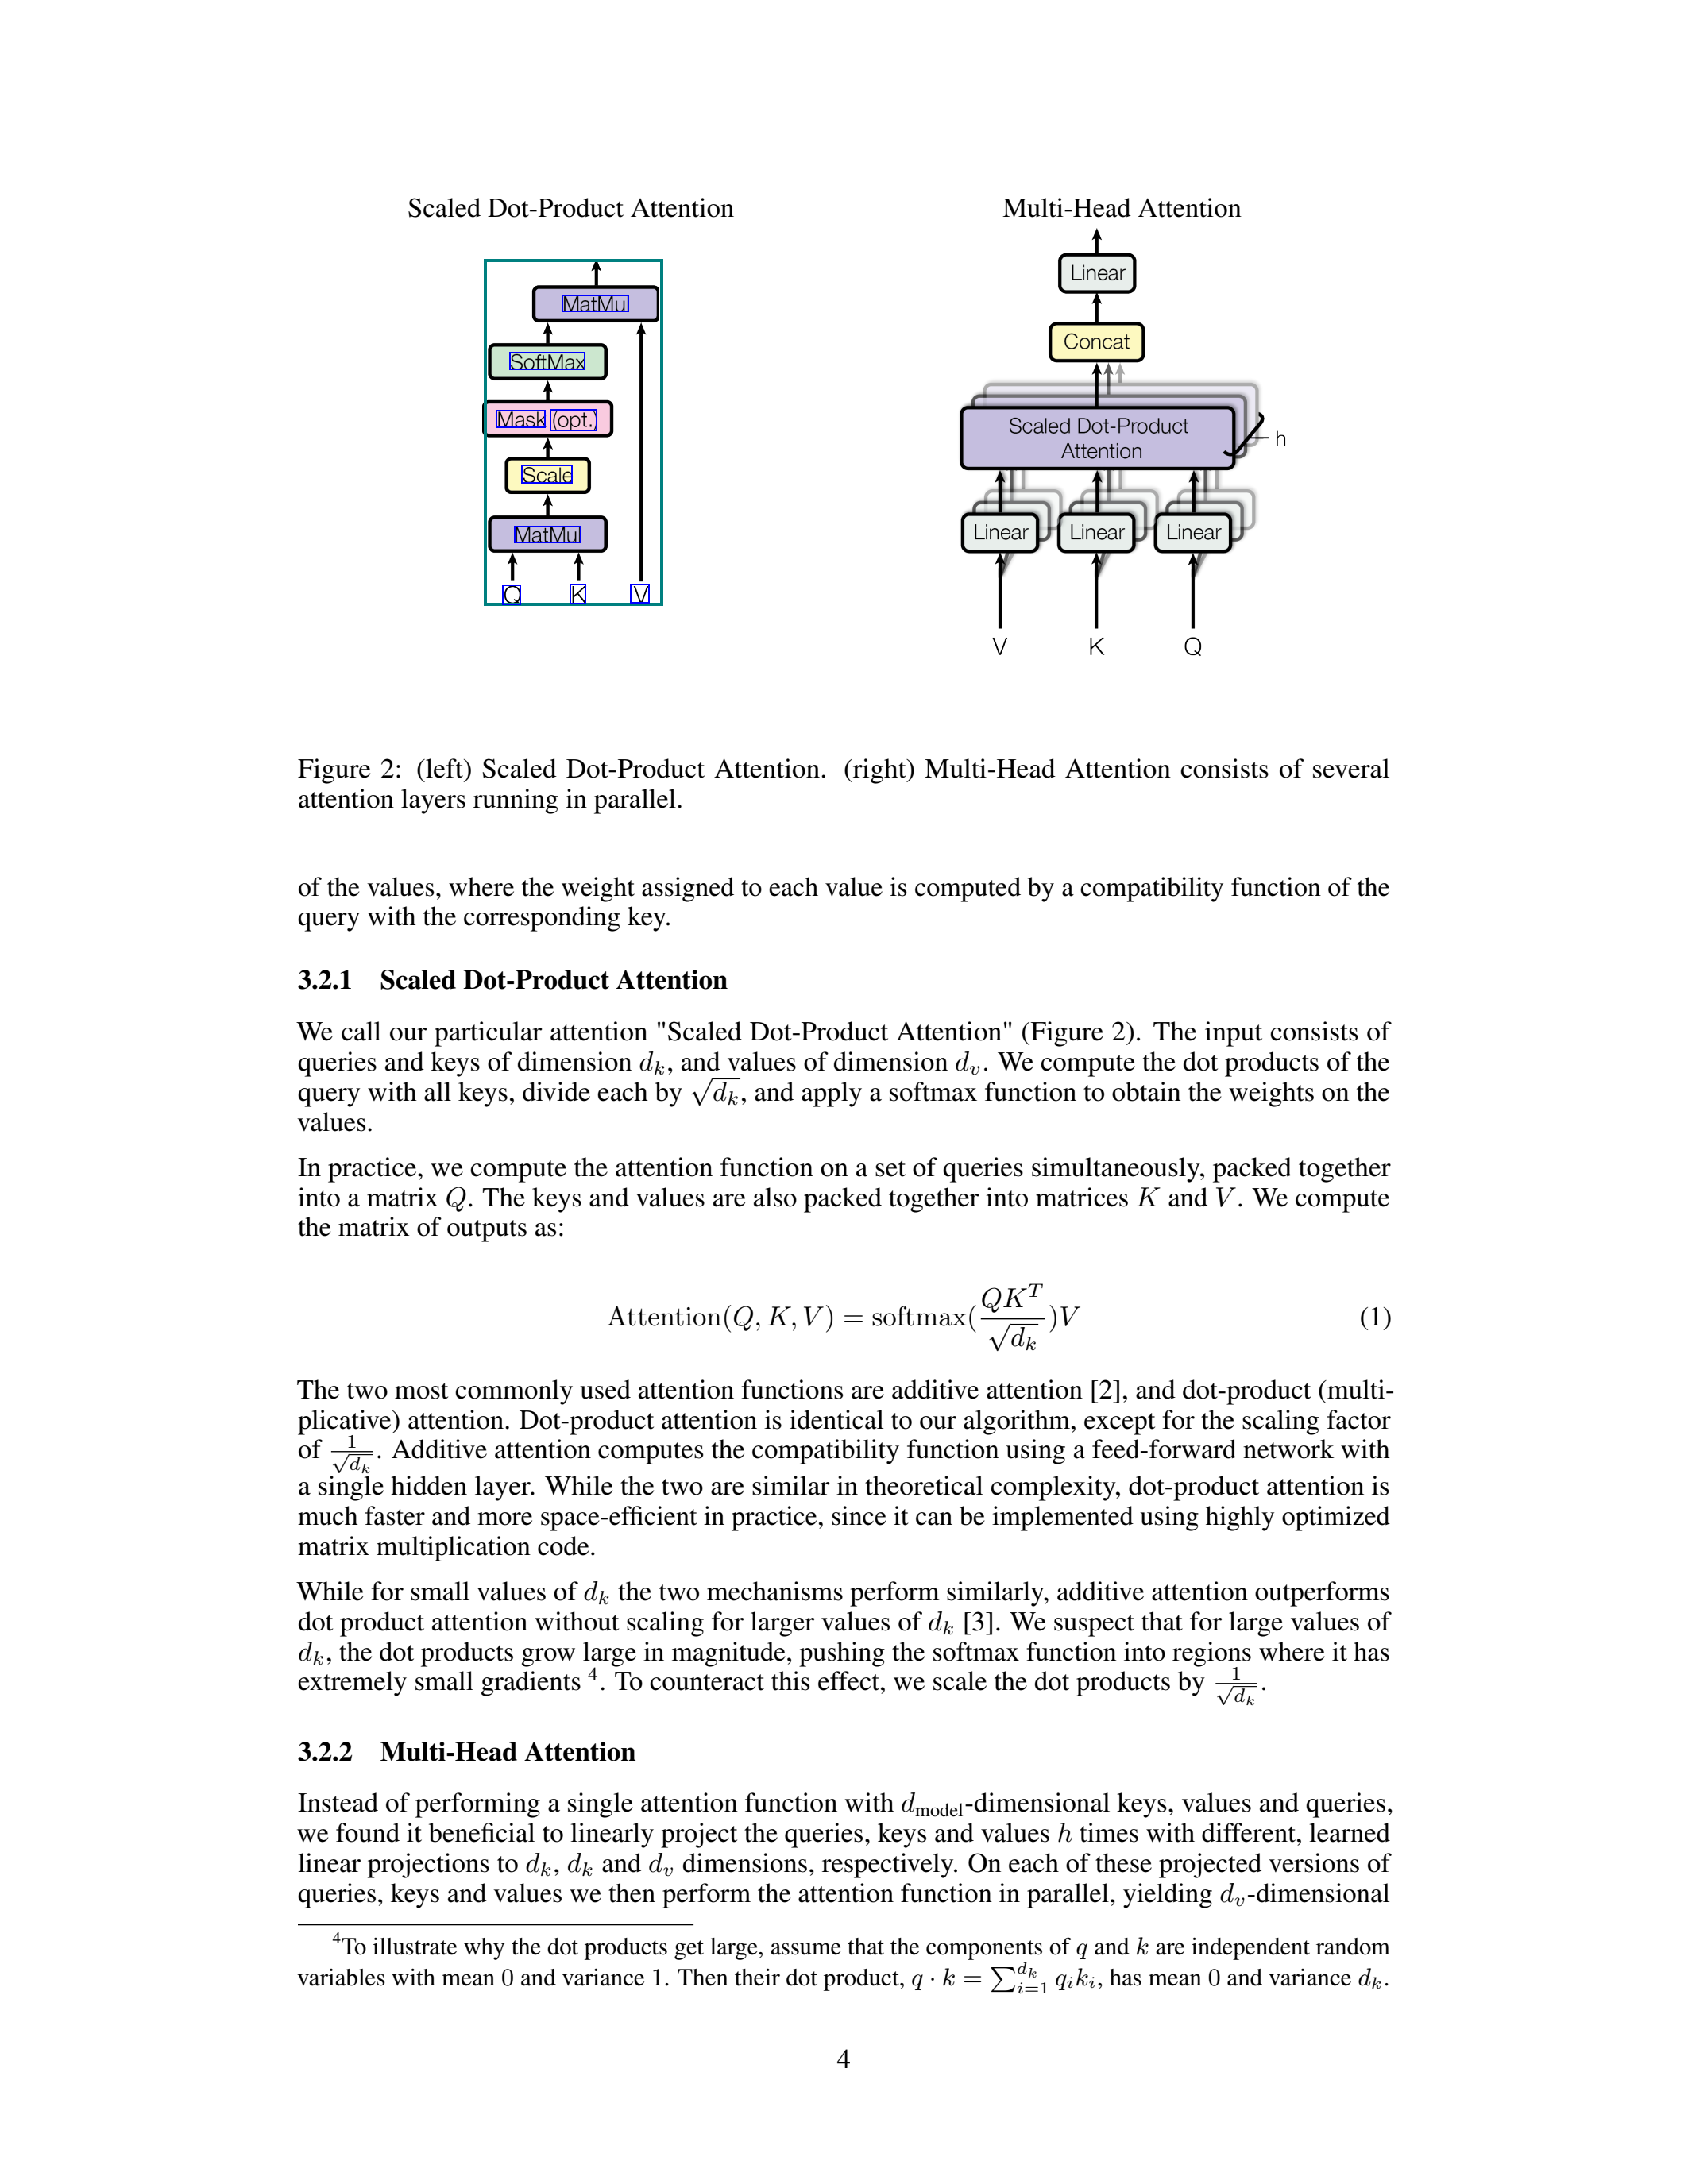

In [30]:
df["layout"].values[33].visualize(with_text=False)


In [ ]:
"

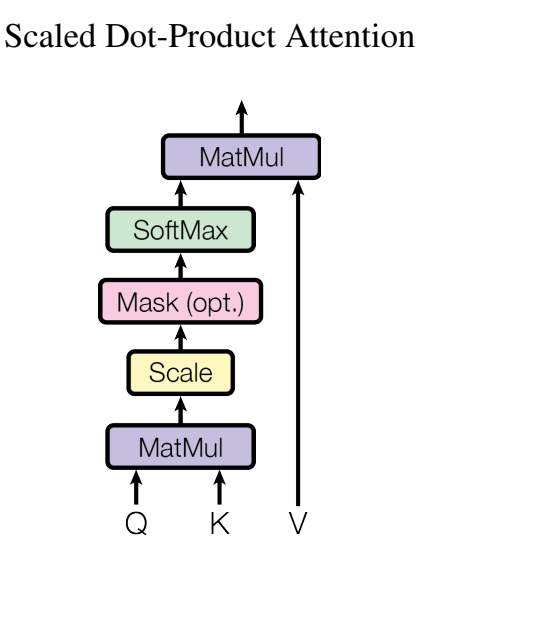

In [31]:
layout = df["layout"].values[33]

def crop_image(layout):
    bbox = layout.bbox
    image = bbox.spatial_object.image
    img_width = image.width
    img_height = image.height
    delta = 100
    image_cut = image.crop((
        int(bbox.x*img_width)-delta, 
        int(bbox.y*img_height)-delta, 
        int((bbox.x+bbox.height)*img_width+delta), 
        int((bbox.y+bbox.height)*img_height+delta)))
    return image_cut

crop_image(layout)